<a href="https://colab.research.google.com/github/dondonrocket/kokudo/blob/%E3%83%86%E3%82%B9%E3%83%88/hasegawa2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [106]:
import pandas as pd
import numpy as np
import geopandas as gpd
import lightgbm as lgb
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

In [107]:
# =========================
# 0. train/test 読み込み
# =========================
train = pd.read_csv("/content/train.csv", encoding="shift_jis", encoding_errors="replace", low_memory=False)
test  = pd.read_csv("/content/test.csv", encoding="shift_jis", encoding_errors="replace", low_memory=False)

In [108]:
# =========================
# DID データ読み込み
# =========================
did_gdf = gpd.read_file("/content/A16-20_00_DID.shp")

# 人口・面積カラム
DID_POP_COL  = "A16_005"
DID_AREA_COL = "A16_006"

# 密度
did_gdf["DID_density"] = did_gdf[DID_POP_COL] / (did_gdf[DID_AREA_COL] + 1e-6)

# CRS統一
did_gdf = did_gdf.to_crs(epsg=3857)

#train / test を GeoDataFrame に変換
train_gdf = gpd.GeoDataFrame(
    train,
    geometry=gpd.points_from_xy(train["lon"], train["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

test_gdf = gpd.GeoDataFrame(
    test,
    geometry=gpd.points_from_xy(test["lon"], test["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

#KDTree用の座標準備
# DIDポリゴンの代表点（centroid）
did_coords = np.vstack([
    did_gdf.geometry.centroid.x,
    did_gdf.geometry.centroid.y
]).T

tree = KDTree(did_coords)

#最近傍DIDを割り当てる関数
def attach_DID_features(base_gdf, did_gdf, tree):
    coords = np.vstack([
        base_gdf.geometry.x,
        base_gdf.geometry.y
    ]).T

    _, idx = tree.query(coords, k=1)

    base_gdf["DID_population"] = did_gdf.iloc[idx.flatten()][DID_POP_COL].values
    base_gdf["DID_area"]       = did_gdf.iloc[idx.flatten()][DID_AREA_COL].values
    base_gdf["DID_density"]    = did_gdf.iloc[idx.flatten()]["DID_density"].values

    return base_gdf

#train / test にDID付与
train_gdf = attach_DID_features(train_gdf, did_gdf, tree)
test_gdf  = attach_DID_features(test_gdf,  did_gdf, tree)

#geometryを落として DataFrame に戻す
train = pd.DataFrame(train_gdf.drop(columns="geometry"))
test  = pd.DataFrame(test_gdf.drop(columns="geometry"))

#欠損処理
for col in ["DID_population", "DID_area", "DID_density"]:
    train[col] = train[col].fillna(0)
    test[col]  = test[col].fillna(0)

    train[f"{col}_log"] = np.log1p(train[col])
    test[f"{col}_log"]  = np.log1p(test[col])


#特徴量に追加
did_features = ['DID_population_log','DID_area_log','DID_density_log'
]

In [109]:
# =========================
# 2. 駅乗降客数（2019年）
# =========================
df = pd.read_csv("S12-24_NumberOfPassengers_utf8.csv")
df_2019 = df[(df["S12_039"]==1)&(df["S12_038"]==1)]
station_2019 = df_2019.groupby("S12_001c", as_index=False).agg(passengers_2019=("S12_041","sum")).rename(columns={"S12_001c":"station_code"})


In [110]:

# =========================
# 3. 駅ポイント（lon / lat）
# =========================
station_point_gdf = gpd.read_file("/content/S12-24_NumberOfPassengers.geojson")
station_point_gdf["S12_001c"] = station_point_gdf["S12_001c"].astype(str)
station_2019["station_code"] = station_2019["station_code"].astype(str)
stations = station_point_gdf.merge(station_2019, left_on="S12_001c", right_on="station_code", how="left")
stations = stations.to_crs(epsg=3857)
stations["geometry"] = stations.geometry.centroid
stations_gdf = stations[["S12_001c","passengers_2019","geometry"]].copy()
stations_gdf.crs = "EPSG:3857"

In [111]:
# =========================
# 4. 駅特徴量作成関数
# =========================
def add_station_features(df, stations_gdf, radius=500):
    df = df.copy()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326").to_crs(epsg=3857)

    # 既存の index_right を削除
    if "index_right" in gdf.columns:
        gdf = gdf.drop(columns=["index_right"])
    if "index_right" in stations_gdf.columns:
        stations_gdf = stations_gdf.drop(columns=["index_right"])

    joined = gpd.sjoin(gdf, stations_gdf, how="left", predicate="dwithin", distance=radius)

    feat = joined.groupby("building_id", as_index=False).agg(
        **{
            f"station_passengers_{radius}m_sum": ("passengers_2019","sum"),
            f"station_passengers_{radius}m_max": ("passengers_2019","max"),
            f"station_passengers_{radius}m_mean": ("passengers_2019","mean")
        }
    )

    df = df.merge(feat, on="building_id", how="left")
    for col in feat.columns:
        if col != "building_id":
            df[col] = df[col].fillna(0)
            df[col + "_log"] = np.log1p(df[col])
    return df

In [112]:

# =========================
# 5. train/testに駅特徴量付与
# =========================
for radius in [500,1000]:
    train = add_station_features(train, stations_gdf, radius)
    test  = add_station_features(test, stations_gdf, radius)

In [113]:

# =========================
# 6. 築年 → 築年数
# =========================
for df in [train,test]:
    df["building_create_date"] = pd.to_numeric(df["building_create_date"], errors="coerce")
    df["age"] = (2023 - df["building_create_date"]).clip(0,100)


In [114]:
# =========================
# 7. 地価公示データ
# =========================
land_gdf = gpd.read_file("/content/L01-23.geojson").to_crs(epsg=4326)
for df in [train,test]:
    df["geometry"] = gpd.points_from_xy(df["lon"], df["lat"])
train_gdf = gpd.GeoDataFrame(train, geometry="geometry", crs="EPSG:4326")
test_gdf  = gpd.GeoDataFrame(test, geometry="geometry", crs="EPSG:4326")
train_gdf = train_gdf.to_crs(epsg=6668)
test_gdf  = test_gdf.to_crs(epsg=6668)
land_gdf  = land_gdf.to_crs(epsg=6668)

land_xy = np.vstack([land_gdf.geometry.x.values, land_gdf.geometry.y.values]).T
tree = KDTree(land_xy)
land_prices = land_gdf['L01_006'].values

def nearest_land_price_fast(pt, tree, land_prices):
    dist, idx = tree.query([[pt.x, pt.y]], k=1)
    return land_prices[idx[0][0]]

train_gdf['nearest_land_price'] = train_gdf['geometry'].apply(lambda pt: nearest_land_price_fast(pt, tree, land_prices))
test_gdf['nearest_land_price']  = test_gdf['geometry'].apply(lambda pt: nearest_land_price_fast(pt, tree, land_prices))
train['final_land_price'] = train_gdf['nearest_land_price'].values
test['final_land_price']  = test_gdf['nearest_land_price'].values

In [115]:
df = pd.read_csv("/content/train.csv")
cols = ['addr1_1', 'addr1_2', 'addr2_name', 'addr3_name']

#df[cols].head(10)
df[cols].isna().sum()
#df[cols].isna().mean().round(3)
#df[cols].isna().sum() + (df[cols] == "").sum()



/tmp/ipython-input-2545586606.py:1: DtypeWarning: Columns (63) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/train.csv")


,0
addr1_1,0
addr1_2,0
addr2_name,2
addr3_name,255609


In [116]:
# =========================
# 特徴量
# =========================
common_features = [
    'target_ym','lon','lat',
    'drugstore_distance','bank_distance','shopping_street_distance',
    'parking_keiyaku','money_hoshou_company','free_rent_duration','free_rent_gen_timing',
    'addr1_1','addr1_2'
]

In [117]:
# =========================
# 時期特徴量
# =========================
BASE_YEAR = 2019

for df in [train, test]:
    df["sale_year"] = df["target_ym"] // 100
    df["year_from_base"] = df["sale_year"] - BASE_YEAR

# =========================
# 年 × 建物種別
# =========================
for df in [train, test]:
    df["is_mansion"] = (df["building_type"] == 1).astype(int)
    df["year_x_mansion"] = df["year_from_base"] * df["is_mansion"]

# =========================
# 年 × 首都圏
# =========================
CAPITAL_PREF_CODES = [13, 14, 12, 11]  # 東京・神奈川・千葉・埼玉

for df in [train, test]:
    df["is_capital"] = df["addr1_1"].isin(CAPITAL_PREF_CODES).astype(int)
    df["year_x_capital"] = df["year_from_base"] * df["is_capital"]

# =========================
# 年 × DID
# =========================
for df in [train, test]:
    df["is_DID"] = (df["DID_population"] > 0).astype(int)
    df["year_x_DID"] = df["year_from_base"] * df["is_DID"]

# =========================
# 4. object型列の数値化（LightGBM対応）
# =========================
for df in [train,test]:
    # money_hoshou_company は object 型になりやすいので数値化
    df["money_hoshou_company"] = pd.to_numeric(df["money_hoshou_company"], errors="coerce").fillna(0)

common_features += [
    "year_from_base",
    "year_x_capital",
    "year_x_DID",
]

# =========================
# 3. マンション・戸建用特徴量
# =========================
mansion_features = common_features + [
    'house_area','room_count','building_structure',
    'DID_population','DID_area','DID_density','final_land_price',
    'station_passengers_500m_sum','station_passengers_500m_max','station_passengers_500m_mean',
    'station_passengers_1000m_sum','station_passengers_1000m_max','station_passengers_1000m_mean',
    "year_x_mansion"
]

house_features = common_features + [
    'house_area','room_count','building_structure',
    'DID_population','DID_area','DID_density','final_land_price',
    'station_passengers_500m_sum','station_passengers_500m_max','station_passengers_500m_mean',
    'station_passengers_1000m_sum','station_passengers_1000m_max','station_passengers_1000m_mean'
]




In [118]:
# =========================
# 1. マンション/戸建てに分割
# =========================
train_mansion = train[train['building_type'] == 1].copy()
train_house   = train[train['building_type'] == 4].copy()
test_mansion  = test[test['building_type'] == 1].copy()
test_house    = test[test['building_type'] == 4].copy()

In [119]:
# =========================
# 3. 学習用データ作成関数
# =========================

DROP_COLS = [
    "id",
    "money_room",
    "money_hoshou_company"
]

def make_features(df):
    return [
        c for c in df.columns
        if c not in DROP_COLS
        and df[c].dtype != "object"
    ]

def prepare_Xy(df, features, is_train=True):
    X = df[[c for c in features if c in df.columns]].copy()

    # geometry が紛れ込んでも必ず落とす
    if "geometry" in X.columns:
        X = X.drop(columns=["geometry"])

    # 数値型だけに限定（最終防衛ライン）
    X = X.select_dtypes(include=[np.number])

    if is_train:
        y = np.log1p(df["money_room"])
        return X, y
    else:
        return X


X_mansion, y_mansion = prepare_Xy(train_mansion, mansion_features)
X_house, y_house     = prepare_Xy(train_house, house_features)

X_test_mansion = test_mansion[mansion_features].copy()
X_test_house   = test_house[house_features].copy()



In [120]:
# =========================
# 4. 学習関数
# =========================
def train_lgb(X, y):
    model = lgb.LGBMRegressor(
        n_estimators=5000,
        learning_rate=0.03,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,

        # Kaggle向け設定
        objective="fair",
        fair_c=0.8,          # ★ ここ重要
        min_child_samples=20,
        reg_alpha=0.1,
        reg_lambda=0.1
    )

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="mape",
        callbacks=[
            lgb.early_stopping(200),
            lgb.log_evaluation(200)
        ]
    )

    return model


In [121]:
# =========================
# 5. モデル学習
# =========================
model_mansion = train_lgb(X_mansion, y_mansion)
model_house   = train_lgb(X_house, y_house)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2725
[LightGBM] [Info] Number of data points in the train set: 155669, number of used features: 20
[LightGBM] [Info] Start training from score 16.925193
Training until validation scores don't improve for 200 rounds
[200]	valid_0's mape: 0.0138686	valid_0's fair: 0.0327818
[400]	valid_0's mape: 0.0133146	valid_0's fair: 0.030627
[600]	valid_0's mape: 0.0129936	valid_0's fair: 0.0294269
[800]	valid_0's mape: 0.0127558	valid_0's fair: 0.0285468
[1000]	valid_0's mape: 0.0125783	valid_0's fair: 0.027907
[1200]	valid_0's mape: 0.0124191	valid_0's fair: 0.0273407
[1400]	valid_0's mape: 0.0122931	valid_0's fair: 0.0268855
[1600]	valid_0's mape: 0.0121758	valid_0's fair: 0.0264706
[1800]	valid_0's mape: 0.0120747	valid_0's fair: 0.026126
[2000]

In [122]:
# =========================
# 1. 学習時の列を保存
# =========================
cols_mansion = X_mansion.columns.tolist()
cols_house   = X_house.columns.tolist()

In [123]:
# =========================
# test を building_type で3分割
# =========================
test_mansion = test[test["building_type"] == 1].copy()
test_house   = test[test["building_type"] == 4].copy()
test_other   = test[
    ~test.index.isin(test_mansion.index) &
    ~test.index.isin(test_house.index)
].copy()

In [124]:
# =========================
# test の特徴量を「学習時列」と完全一致
# =========================
X_test_mansion = test_mansion.reindex(
    columns=cols_mansion,
    fill_value=0
)

X_test_house = test_house.reindex(
    columns=cols_house,
    fill_value=0
)

X_test_other = test_other.reindex(
    columns=cols_mansion,
    fill_value=0
)

In [125]:
# =========================
# 3. 低価格帯補正つき予測
# =========================
LOW_TH_MANSION = 9_000_000
LOW_TH_HOUSE   = 9_000_000

LOW_SCALE_MANSION = 0.83
LOW_SCALE_HOUSE   = 0.83


def predict_with_low_scale(model, X, low_th, low_scale):
    y_pred = model.predict(X)

    # まず予測値側をガード
    y_pred = np.nan_to_num(
        y_pred,
        nan=0.0,
        posinf=20,   # log空間での上限
        neginf=0.0
    )

    # log → 元スケール
    y_pred = np.expm1(y_pred)

    # 再度ガード
    y_pred = np.nan_to_num(
        y_pred,
        nan=0.0,
        posinf=1e9,
        neginf=0.0
    )

    # 下限クリップ
    y_pred = np.clip(y_pred, 1, 1e9)

    # 低価格帯補正
    mask_low = y_pred <= low_th
    y_pred[mask_low] *= low_scale

    return y_pred

# y_pred_test_mansion = predict_with_low_scale(
#     model_mansion, X_test_mansion, LOW_TH_MANSION, LOW_SCALE_MANSION
# )

# y_pred_test_house = predict_with_low_scale(
#     model_house, X_test_house, LOW_TH_HOUSE, LOW_SCALE_HOUSE
# )

# y_pred_test_other = predict_with_low_scale(
#     model_mansion, X_test_other, LOW_TH_MANSION, LOW_SCALE_MANSION
# )

/tmp/ipython-input-1026423258.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby("price_bin")["ape"].mean().plot(marker="o")
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20307 (\N{CJK UNIFIED IDEOGRAPH-4F53}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


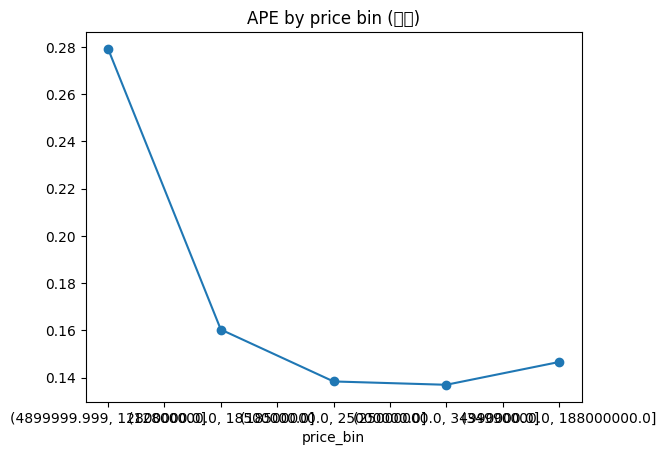

In [126]:
# =========================
# 6. trainに予測値とAPEを追加
# =========================
train_mansion["pred"] = predict_with_low_scale(model_mansion, X_mansion, LOW_TH_MANSION, LOW_SCALE_MANSION)
train_mansion["ape"]  = np.abs(train_mansion["pred"] - train_mansion["money_room"]) / train_mansion["money_room"]

train_house["pred"] = predict_with_low_scale(model_house, X_house, LOW_TH_HOUSE, LOW_SCALE_HOUSE)
train_house["ape"] = np.abs(train_house["pred"] - train_house["money_room"]) / train_house["money_room"]

train["pred"] = np.nan
train["ape"]  = np.nan
train.loc[train_mansion.index, "pred"] = train_mansion["pred"]
train.loc[train_mansion.index, "ape"]  = train_mansion["ape"]
train.loc[train_house.index, "pred"] = train_house["pred"]
train.loc[train_house.index, "ape"]  = train_house["ape"]

# =========================
# 7. APE by price bin
# =========================
train["price_bin"] = pd.qcut(train["money_room"], q=5, duplicates="drop")
train.groupby("price_bin")["ape"].mean().plot(marker="o")
plt.title("APE by price bin (全体)")
plt.show()

# =========================
# 8. test に予測値を書き込む
# =========================
y_pred_test_mansion = predict_with_low_scale(model_mansion, X_test_mansion, LOW_TH_MANSION, LOW_SCALE_MANSION)
y_pred_test_house   = predict_with_low_scale(model_house, X_test_house, LOW_TH_HOUSE, LOW_SCALE_HOUSE)
y_pred_test_other   = predict_with_low_scale(model_mansion, X_test_other, LOW_TH_MANSION, LOW_SCALE_MANSION)


In [127]:
# =========================
# 4. test DataFrame に書き戻す
# =========================
test.loc[test_mansion.index, "money_room"] = y_pred_test_mansion
test.loc[test_house.index,   "money_room"] = y_pred_test_house
test.loc[test_other.index,   "money_room"] = y_pred_test_other

test["money_room"] = test["money_room"].fillna(
    test["money_room"].median()
)


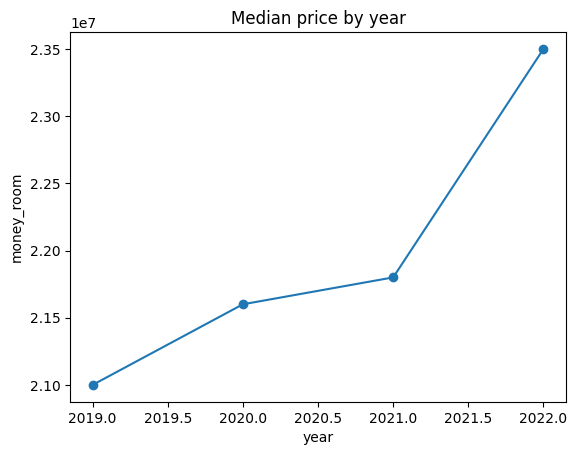

In [128]:
# =========================
# 時期特徴量が「本当に価格上昇を表現できているか」→右肩上がりなら「時期特徴量を入れる判断は完全に正解」
# =========================
import matplotlib.pyplot as plt

plt.figure()
train.groupby("sale_year")["money_room"].median().plot(marker="o")
plt.title("Median price by year")
plt.xlabel("year")
plt.ylabel("money_room")
plt.show()


<Figure size 640x480 with 0 Axes>

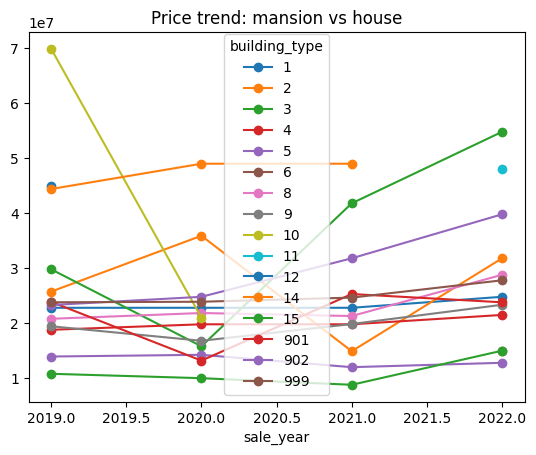

In [129]:
# =========================
# マンション vs 戸建の「上がり方の違い」→マンションの傾き > 戸建→ year_x_mansion が理にかなう
# =========================
plt.figure()
train.groupby(["sale_year","building_type"])["money_room"].median().unstack().plot(marker="o")
plt.title("Price trend: mansion vs house")
plt.show()


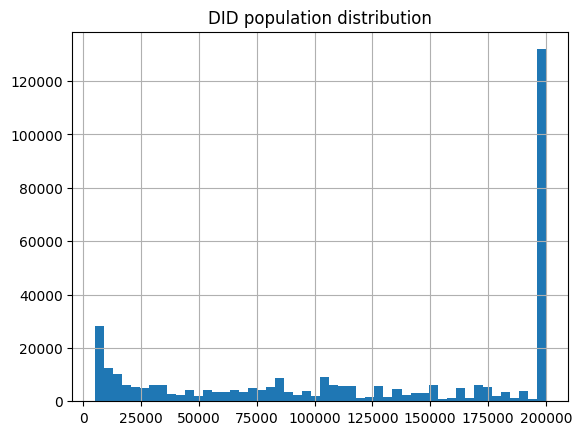

In [130]:
# =========================
# DIDは「成長率」なのか？→年ごとに増えている → DIDは成長代理変数として成立、横ばい → 単なる立地変数
# =========================
plt.figure()
train["DID_population"].clip(0,200000).hist(bins=50)
plt.title("DID population distribution")
plt.show()


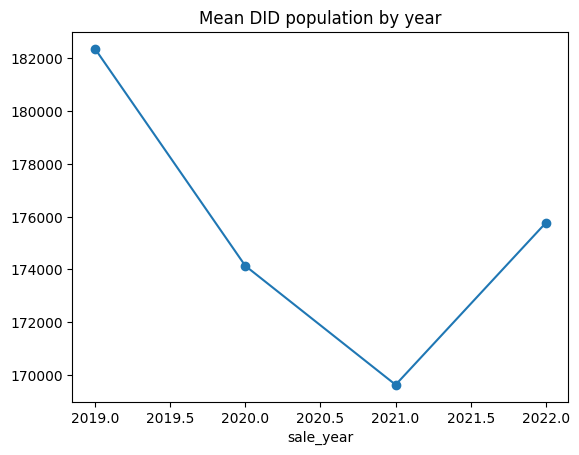

In [131]:
# =========================
#
# =========================
plt.figure()
train.groupby("sale_year")["DID_population"].mean().plot(marker="o")
plt.title("Mean DID population by year")
plt.show()


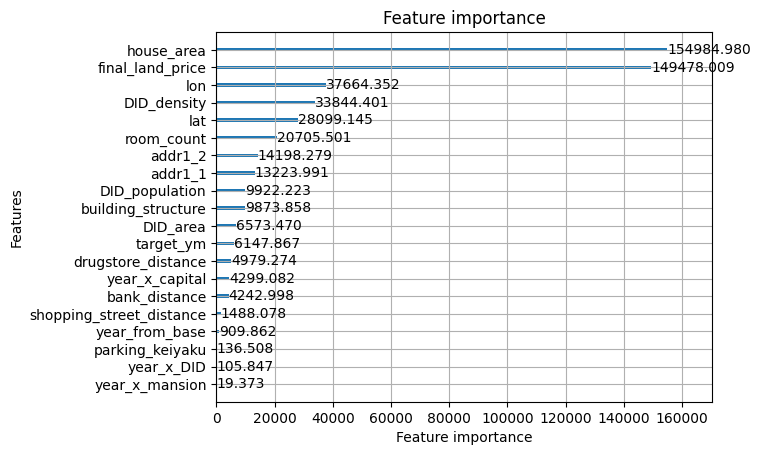

In [132]:
# =========================
# モデルが「何を信用しているか」→year_from_base、year_x_mansion、year_x_capital、year_x_DIDが 上位に来ているか。
#来ていなければ、スケール、対数化、交互作用の作り方を調整対象にする
# =========================
lgb.plot_importance(
    model_mansion,
    max_num_features=30,
    importance_type="gain"
)
plt.show()


In [133]:
# =========================
# 低価格帯が救われているか（超重要）→低価格帯の APE が明確に下がる
# =========================
train["pred"] = np.expm1(model_mansion.predict(X_mansion))
train["ape"] = np.abs(train["pred"] - train["money_room"]) / train["money_room"]

train["price_bin"] = pd.qcut(train["money_room"], q=5)

train.groupby("price_bin")["ape"].mean().plot(marker="o")
plt.title("APE by price bin")
plt.show()


ValueError: Length of values (194587) does not match length of index (363924)

In [ ]:
# =========================
# 5. submit.csv 作成
# =========================
submit = test[["id", "money_room"]].sort_values("id")
submit.to_csv("submit.csv", index=False, header=False)

# NaN 確認
import pandas as pd
pd.read_csv("submit.csv").isna().sum()
